In [ ]:
import librosa
import librosa.display
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import accuracy_score, adjusted_rand_score, normalized_mutual_info_score, confusion_matrix
from sklearn.manifold import TSNE
from scipy.stats import mode


In [ ]:
# Load Metadata
metadata = pd.read_csv("/content/drive/MyDrive/ESC-50-master/meta/esc50.csv")

# Define animal classes to filter
animal_classes = ['dog', 'rooster', 'pig', 'cow', 'frog', 'cat', 'hen', 'insects', 'sheep', 'crow']

# Filter dataset for only animal sounds
filtered_data = metadata[metadata['category'].isin(animal_classes)]

# Display first few rows to verify
filtered_data.head()


,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
8,1-103298-A-9.wav,1,9,crow,False,103298,A
14,1-110389-A-0.wav,1,0,dog,True,110389,A
29,1-121951-A-8.wav,1,8,sheep,False,121951,A
45,1-15689-A-4.wav,1,4,frog,False,15689,A


In [ ]:
import librosa
import numpy as np

def extract_features(y, sr):

    # Extract features
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    delta_mfcc = librosa.feature.delta(mfcc)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y)
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    rms = librosa.feature.rms(y=y)  # Root Mean Square Energy

    # Harmonic-Percussive Separation
    y_harmonic, y_percussive = librosa.effects.hpss(y)
    tonnetz = librosa.feature.tonnetz(y=y_harmonic, sr=sr)

    # Ensure safe mean calculation
    def safe_mean(feature):
        return np.mean(feature, axis=1) if feature.ndim > 1 else np.array([np.mean(feature)])

    # Combine extracted features
    return np.hstack([
        safe_mean(mfcc),
        safe_mean(delta_mfcc),
        safe_mean(chroma),
        safe_mean(spectral_centroid),
        safe_mean(zero_crossing_rate),
        safe_mean(spectral_bandwidth),
        safe_mean(rms),
        safe_mean(tonnetz)
    ])


def augment_audio(y, sr):

    # Add Gaussian noise
    noise = np.random.randn(len(y))
    y_noise = y + 0.005 * noise

    n_steps = np.random.choice([-2, -1, 1, 2])
    y_pitch = librosa.effects.pitch_shift(y=y, sr=sr, n_steps=n_steps)

    # Time stretching
    stretch_rate = np.random.uniform(0.8, 1.2)
    y_stretch = librosa.effects.time_stretch(y, rate=stretch_rate)

    return [y, y_noise, y_pitch, y_stretch]  # Return original + augmented versions

features, labels = [], []

for _, row in filtered_data.iterrows():
    audio_path = f"/content/drive/MyDrive/ESC-50-master/audio/{row['filename']}"
    y, sr = librosa.load(audio_path, sr=None)

    # Generate augmented versions
    augmented_audios = augment_audio(y, sr)

    for aug_audio in augmented_audios:
        feature_vector = extract_features(aug_audio, sr)
        features.append(feature_vector)
        labels.append(row['category'])

# Convert to NumPy array
features = np.array(features)
ground_truth_labels = np.array(labels)



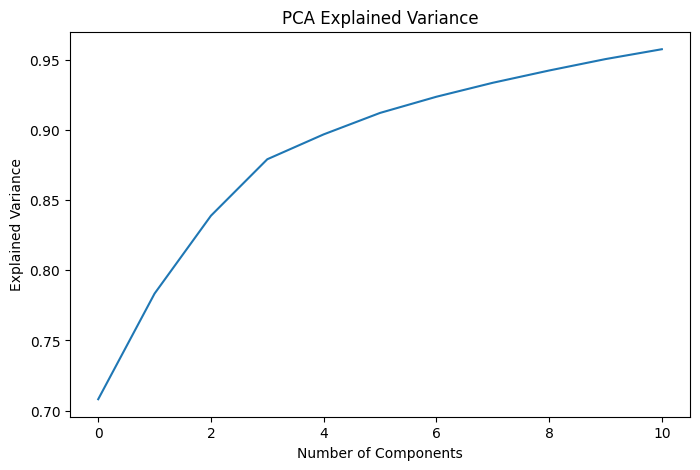

In [ ]:
# Normalize and Scale Features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply PCA for Dimensionality Reduction
pca = PCA(n_components=11)
features_pca = pca.fit_transform(features_scaled)


# Check variance explained by PCA components
plt.figure(figsize=(8,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('PCA Explained Variance')
plt.show()


In [ ]:
# Apply K-Means Clustering
kmeans = KMeans(n_clusters=12, random_state=42)
clusters = kmeans.fit_predict(features_pca)

#from sklearn.cluster import DBSCAN, AgglomerativeClustering

# DBSCAN (good if there are density-based clusters)
#dbscan = DBSCAN(eps=0.5, min_samples=5)
#clusters = dbscan.fit_predict(features_pca)

# Agglomerative Clustering (good for hierarchical structures)
#agg_clustering = AgglomerativeClustering(n_clusters=10)
#clusters = agg_clustering.fit_predict(features_pca)

#from sklearn.mixture import GaussianMixture

#gmm = GaussianMixture(n_components=7, random_state=42)
#clusters = gmm.fit_predict(features_pca)


In [ ]:
from scipy.optimize import linear_sum_assignment
import numpy as np

def map_clusters_to_labels_hungarian(cluster_labels, true_labels):
    unique_clusters = np.unique(cluster_labels)

    # Ignore noise points (-1) if present
    if -1 in unique_clusters:
        unique_clusters = unique_clusters[unique_clusters != -1]

    num_clusters = len(unique_clusters)
    num_labels = len(np.unique(true_labels))

    contingency_matrix = np.zeros((num_clusters, num_labels))

    for i in range(len(cluster_labels)):
        if cluster_labels[i] != -1:
            cluster_idx = np.where(unique_clusters == cluster_labels[i])[0][0]
            label_idx = np.where(np.unique(true_labels) == true_labels[i])[0][0]
            contingency_matrix[cluster_idx, label_idx] += 1

    row_ind, col_ind = linear_sum_assignment(-contingency_matrix)
    cluster_to_label = {unique_clusters[row]: np.unique(true_labels)[col] for row, col in zip(row_ind, col_ind)}

    return np.array([cluster_to_label.get(c, -1) for c in cluster_labels])



In [ ]:
mapped_labels = map_clusters_to_labels_hungarian(clusters, ground_truth_labels)

accuracy = accuracy_score(ground_truth_labels, mapped_labels)
ari = adjusted_rand_score(ground_truth_labels, clusters)
nmi = normalized_mutual_info_score(ground_truth_labels, clusters)

print(f"Accuracy: {accuracy:.2f}")
print(f"Adjusted Rand Index (ARI): {ari:.2f}")
print(f"Normalized Mutual Information (NMI): {nmi:.2f}")


Accuracy: 0.24
Adjusted Rand Index (ARI): 0.07
Normalized Mutual Information (NMI): 0.17


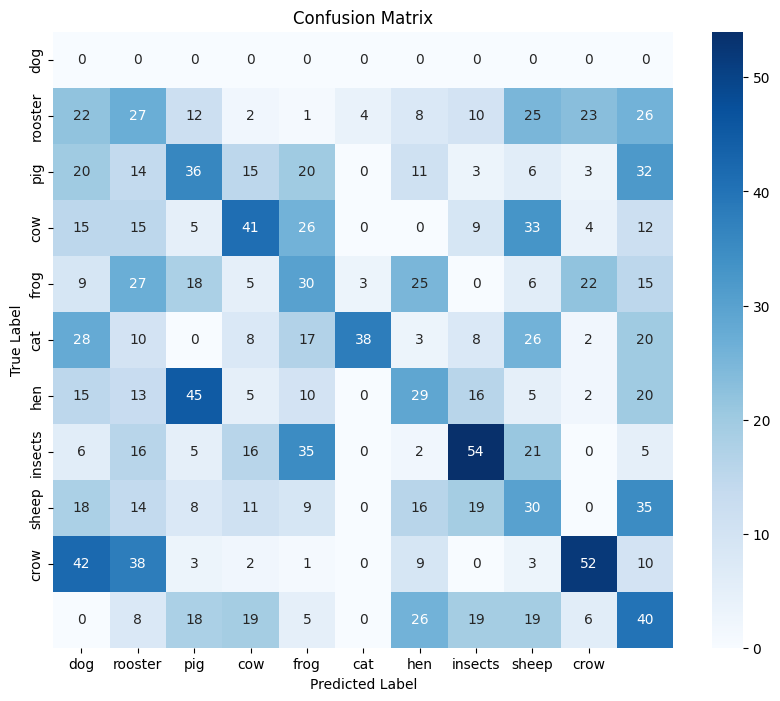

In [ ]:
cm = confusion_matrix(ground_truth_labels, mapped_labels)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=animal_classes, yticklabels=animal_classes, cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


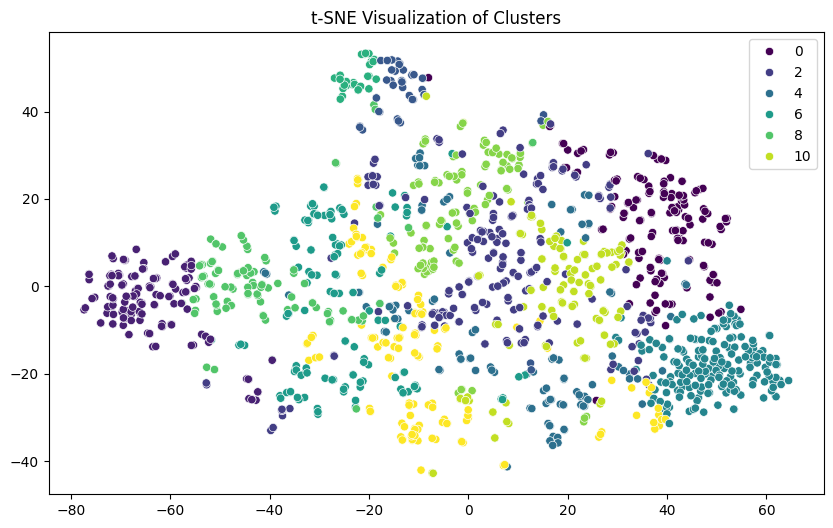

In [ ]:
# Apply t-SNE for Visualization
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
features_tsne = tsne.fit_transform(features_pca)

# Plot t-SNE
plt.figure(figsize=(10, 6))
sns.scatterplot(x=features_tsne[:, 0], y=features_tsne[:, 1], hue=clusters, palette='viridis')
plt.title("t-SNE Visualization of Clusters")
plt.show()


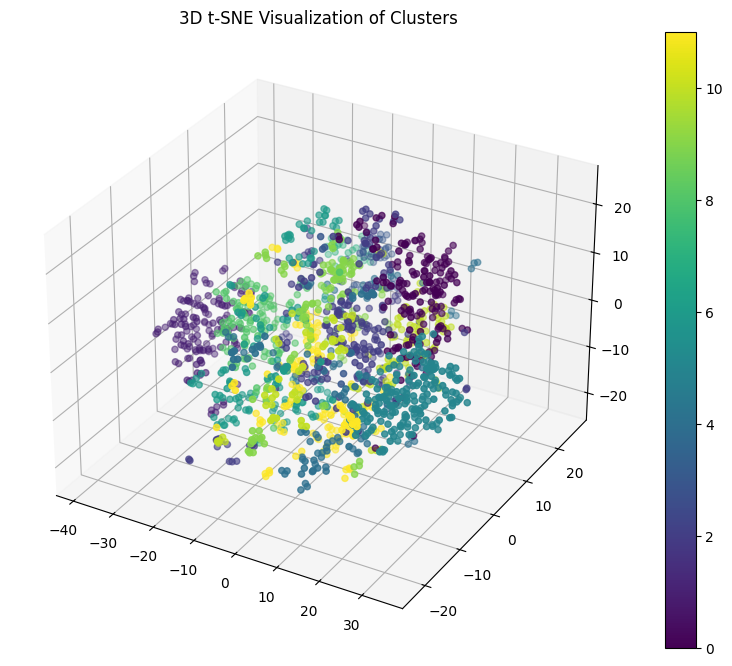

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, perplexity=30, random_state=42)
features_tsne = tsne.fit_transform(features_pca)

# Plotting
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(features_tsne[:, 0], features_tsne[:, 1], features_tsne[:, 2], c=clusters, cmap='viridis')
plt.title("3D t-SNE Visualization of Clusters")
plt.colorbar(scatter)
plt.show()


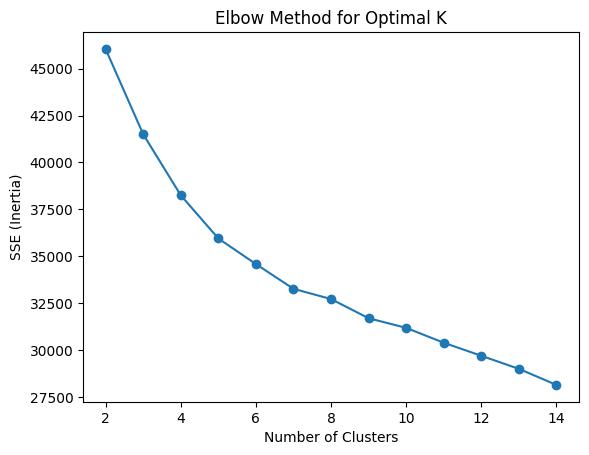

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

sse = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_pca)
    sse.append(kmeans.inertia_)

plt.plot(range(2, 15), sse, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("SSE (Inertia)")
plt.title("Elbow Method for Optimal K")
plt.show()


Trying by Autoencoder

In [43]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.manifold import TSNE
from scipy.stats import mode


In [70]:
# Adjust paths for your environment
metadata_path = "/content/drive/MyDrive/ESC-50-master/meta/esc50.csv"
metadata = pd.read_csv(metadata_path)

animal_classes = ['dog','rooster','pig','cow','frog','cat','hen','insects','sheep','crow']
filtered_data = metadata[metadata['category'].isin(animal_classes)]
print(f"Filtered dataset size: {len(filtered_data)}")


Filtered dataset size: 400


In [75]:

def fix_spect_shape(mel_spec_db, desired_frames=88):
    """
    Force mel_spec_db to have 'desired_frames' columns.
    If it's shorter, pad with zeros; if it's longer, truncate.
    """
    cur_frames = mel_spec_db.shape[1]
    if cur_frames < desired_frames:
        pad_amount = desired_frames - cur_frames
        mel_spec_db = np.pad(mel_spec_db, ((0, 0), (0, pad_amount)), mode='constant')
    elif cur_frames > desired_frames:
        mel_spec_db = mel_spec_db[:, :desired_frames]
    return mel_spec_db

def augment_audio_waveform(y, sr):
    """
    Apply random pitch shift and time stretch to the waveform.
    Returns a list of augmented versions (including the original).
    """
    augmented = [y]  # original

    # Random pitch shift: ±2 semitones
    n_steps = np.random.uniform(-2, 2)
    y_pitch = librosa.effects.pitch_shift(y, sr=sr, n_steps=n_steps)
    augmented.append(y_pitch)

    # Random time stretch: rate between 0.8 and 1.2
    rate = np.random.uniform(0.8, 1.2)
    try:
        y_stretch = librosa.effects.time_stretch(y, rate=rate)
    except Exception as e:
        # In rare cases, time stretching might fail; use original
        y_stretch = y
    augmented.append(y_stretch)

    return augmented

def load_and_augment_melspec(audio_path, sr=22050, duration=2.0, n_mels=128, hop_length=512, desired_frames=88):
    """
    1) Load audio and pad/truncate to a fixed duration.
    2) Augment the waveform.
    3) Convert each augmented waveform to a mel spectrogram.
    4) Normalize and fix the spectrogram shape.
    Returns a list of mel spectrogram arrays with shape (n_mels, desired_frames).
    """
    y, sr = librosa.load(audio_path, sr=sr)
    target_len = int(sr * duration)
    if len(y) < target_len:
        y = np.pad(y, (0, target_len - len(y)))
    else:
        y = y[:target_len]

    # Get augmented versions (original, pitch shifted, time stretched)
    aug_waveforms = augment_audio_waveform(y, sr)

    specs = []
    for aug_wf in aug_waveforms:
        mel_spec = librosa.feature.melspectrogram(y=aug_wf, sr=sr, n_mels=n_mels, hop_length=hop_length)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        # Normalize the spectrogram
        mel_spec_db = (mel_spec_db - mel_spec_db.mean()) / (mel_spec_db.std() + 1e-6)
        # Force consistent shape
        mel_spec_db = fix_spect_shape(mel_spec_db, desired_frames=desired_frames)
        specs.append(mel_spec_db)
    return specs


In [76]:
audio_folder = "/content/drive/MyDrive/ESC-50-master/audio"

X_specs = []
Y_labels = []

for _, row in filtered_data.iterrows():
    audio_path = os.path.join(audio_folder, row['filename'])
    augmented_specs = load_and_augment_melspec(audio_path, desired_frames=88)
    for spec in augmented_specs:
        X_specs.append(spec)
        Y_labels.append(row['category'])

# Convert to NumPy arrays
X_specs = np.array(X_specs)  # Expected shape: (num_samples, n_mels, desired_frames)
Y_labels = np.array(Y_labels)

print("Shape of X_specs:", X_specs.shape)
print("Shape of Y_labels:", Y_labels.shape)

# Expand dims for CNN (add channel dimension)
X_specs = np.expand_dims(X_specs, axis=-1)  # Now shape: (num_samples, 128, 88, 1)
print("After expanding dims:", X_specs.shape)

Shape of X_specs: (1200, 128, 88)
Shape of Y_labels: (1200,)
After expanding dims: (1200, 128, 88, 1)


In [77]:
def build_cnn_autoencoder(input_shape=(128, 88, 1), latent_dim=64, dropout_rate=0.2):
    """
    Returns (autoencoder, encoder, decoder) models.
    """
    encoder_input = layers.Input(shape=input_shape, name="Encoder_Input")

    # ---- Encoder ----
    x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(encoder_input)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2), padding='same')(x)
    x = layers.Dropout(dropout_rate)(x)

    x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2), padding='same')(x)
    x = layers.Dropout(dropout_rate)(x)

    x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2), padding='same')(x)
    x = layers.Dropout(dropout_rate)(x)

    # Flatten and create latent vector
    x = layers.Flatten()(x)
    latent = layers.Dense(latent_dim, activation='relu', name="Latent")(x)

    encoder = models.Model(encoder_input, latent, name="Encoder")

    # ---- Decoder ----
    decoder_input = layers.Input(shape=(latent_dim,), name="Decoder_Input")

    # Determine shape after 3 poolings:
    reshape_h = input_shape[0] // 8  # 128//8 = 16
    reshape_w = input_shape[1] // 8  # 88//8 = 11
    reshape_ch = 128

    x = layers.Dense(reshape_h * reshape_w * reshape_ch, activation='relu')(decoder_input)
    x = layers.Reshape((reshape_h, reshape_w, reshape_ch))(x)

    x = layers.Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)

    x = layers.Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)

    x = layers.Conv2DTranspose(32, (3,3), strides=(2,2), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)

    # Final layer to reconstruct original input shape
    x = layers.Conv2DTranspose(1, (3,3), padding='same', activation='linear')(x)

    # If the decoder output shape is off by one (e.g. 128x89 vs. 128x88), crop it:
    if x.shape[2] != input_shape[1]:
        # Crop on the right side
        crop_amount = int(x.shape[2]) - input_shape[1]
        x = layers.Cropping2D(((0,0),(0,crop_amount)))(x)

    decoder = models.Model(decoder_input, x, name="Decoder")

    # ---- Full Autoencoder ----
    auto_input = encoder_input
    encoded = encoder(auto_input)
    decoded = decoder(encoded)
    autoencoder = models.Model(auto_input, decoded, name="Autoencoder")
    autoencoder.compile(optimizer='adam', loss='mse')

    return autoencoder, encoder, decoder

# Build the autoencoder using the fixed input shape from our spectrograms
input_shape = (128, 88, 1)
autoencoder, encoder, decoder = build_cnn_autoencoder(input_shape=input_shape, latent_dim=64, dropout_rate=0.2)
autoencoder.summary()

Model: "Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Encoder_Input (InputLayer)           │ (None, 128, 88, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Encoder (Functional)                 │ (None, 64)                  │       1,535,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Decoder (Functional)                 │ (None, 128, 88, 1)          │       1,705,345 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,240,769 (12.36 MB)

 Trainable params: 3,239,873 (12.36 MB)

 Non-trainable params: 896 (3.50 KB)

In [78]:

history = autoencoder.fit(
    X_specs, X_specs,
    epochs=50,            # Increase epochs for potentially better convergence
    batch_size=8,
    shuffle=True,
    verbose=1
)

print("Autoencoder training complete.")


Epoch 1/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 104s 627ms/step - loss: 1.2631
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 144s 640ms/step - loss: 0.3715
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 140s 623ms/step - loss: 0.2715
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 144s 642ms/step - loss: 0.2358
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 139s 619ms/step - loss: 0.2182
Epoch 6/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 97s 644ms/step - loss: 0.1988
Epoch 7/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 94s 630ms/step - loss: 0.1881
Epoch 8/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 92s 611ms/step - loss: 0.1846
Epoch 9/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 146s 641ms/step - loss: 0.1739
Epoch 10/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 92s 615ms/step - loss: 0.1661
Epoch 11/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 146s 641ms/step - loss: 0.1650
Epoch 12/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 142s 640ms/step - loss: 0.1586
Epoch 13/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 141s 635ms/step - loss: 0.1564
Epoch 14/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 96s 643ms/step - loss: 0.1488
Epoch 

In [79]:
latent_vectors = encoder.predict(X_specs)
print("Latent shape:", latent_vectors.shape)

def map_clusters_to_labels(cluster_labels, true_labels):
    unique_clusters = np.unique(cluster_labels)
    cluster_to_label = {}

    unique_labels = np.unique(true_labels)
    label_to_int = {lbl: i for i, lbl in enumerate(unique_labels)}
    int_to_label = {i: lbl for lbl, i in label_to_int.items()}
    true_labels_numeric = np.array([label_to_int[lbl] for lbl in true_labels])

    for c in unique_clusters:
        idx = np.where(cluster_labels == c)[0]
        if len(idx) == 0:
            cluster_to_label[c] = -1
            continue
        cluster_labels_in_cluster = true_labels_numeric[idx]
        most_common_label = int(mode(cluster_labels_in_cluster, keepdims=True).mode[0])
        cluster_to_label[c] = most_common_label

    mapped = []
    for c in cluster_labels:
        mapped.append(int_to_label[cluster_to_label[c]]) if c in cluster_to_label else mapped.append("Unknown")
    return np.array(mapped)

def evaluate_clustering(latent_data, true_labels, method_name, cluster_labels):
    mapped_labels = map_clusters_to_labels(cluster_labels, true_labels)
    acc = accuracy_score(true_labels, mapped_labels)
    ari = adjusted_rand_score(true_labels, cluster_labels)
    nmi = normalized_mutual_info_score(true_labels, cluster_labels)
    print(f"\n[ {method_name} ]")
    print(f"Accuracy: {acc:.3f}")
    print(f"ARI:      {ari:.3f}")
    print(f"NMI:      {nmi:.3f}")

k = 10  # you have 10 classes

# K-Means
kmeans = KMeans(n_clusters=k, random_state=42)
km_labels = kmeans.fit_predict(latent_vectors)
evaluate_clustering(latent_vectors, Y_labels, "K-Means", km_labels)

# Gaussian Mixture
gmm = GaussianMixture(n_components=k, random_state=42)
gmm_labels = gmm.fit_predict(latent_vectors)
evaluate_clustering(latent_vectors, Y_labels, "GaussianMixture", gmm_labels)

# Agglomerative
agg = AgglomerativeClustering(n_clusters=k)
agg_labels = agg.fit_predict(latent_vectors)
evaluate_clustering(latent_vectors, Y_labels, "Agglomerative", agg_labels)

# DBSCAN
dbscan = DBSCAN(eps=3.0, min_samples=5)
dbscan_labels = dbscan.fit_predict(latent_vectors)
evaluate_clustering(latent_vectors, Y_labels, "DBSCAN", dbscan_labels)


38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 264ms/step
Latent shape: (1200, 64)

[ K-Means ]
Accuracy: 0.353
ARI:      0.150
NMI:      0.251

[ GaussianMixture ]
Accuracy: 0.267
ARI:      0.051
NMI:      0.171

[ Agglomerative ]
Accuracy: 0.356
ARI:      0.133
NMI:      0.259

[ DBSCAN ]
Accuracy: 0.100
ARI:      0.000
NMI:      0.000


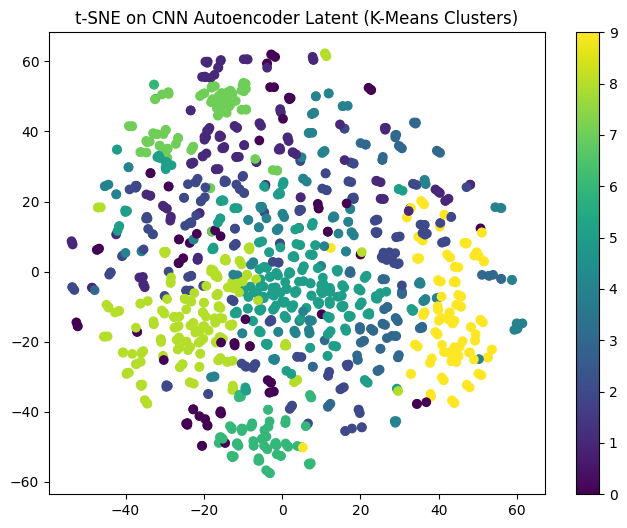

In [80]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_data = tsne.fit_transform(latent_vectors)

plt.figure(figsize=(8,6))
plt.scatter(tsne_data[:,0], tsne_data[:,1], c=km_labels, cmap='viridis')
plt.colorbar()
plt.title("t-SNE on CNN Autoencoder Latent (K-Means Clusters)")
plt.show()
